In [54]:
%matplotlib inline

In [52]:
import tensorflow as tf
import pandas as pd
import numpy as np
import seaborn as sns
import scipy as sp

In [8]:
simlex = pd.read_csv('SimLex-999.txt', sep='\t', index_col=['word1', 'word2'])

In [48]:
simlex = simlex[
    (simlex.index.get_level_values('word1') != 'bubble') &
    (simlex.index.get_level_values('word1') != 'disorganize') &
    True
]

In [59]:
with open('metadata.tsv') as f:
    word_index = {w.strip(): i for i, w in enumerate(f)}

In [28]:
vocabulary_size = 161048
embedding_size = 300

In [61]:
g = tf.Graph()

with g.as_default(), tf.device('/cpu:0'):

    column_a = tf.placeholder(tf.int32, shape=None, name='column_a')
    column_b = tf.placeholder(tf.int32, shape=None, name='column_b')
    
    embeddings = tf.Variable(tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0), name='embeddings')
    norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True), name='norm')
    normalized_embeddings = embeddings / norm

    embeddings_a = tf.nn.embedding_lookup(normalized_embeddings, column_a, name='embeddings_a')
    embeddings_b = tf.nn.embedding_lookup(normalized_embeddings, column_b, name='embeddings_b')
    
    similarity = tf.reduce_sum(embeddings_a * embeddings_b, 1, keep_dims=True)
    saver = tf.train.Saver()
    
with tf.Session(graph=g) as sess:
    saver.restore(sess, 'notebook_runs/model.ckpt-37122376')
    
    x = [word_index[w] for w in simlex.index.get_level_values('word1')]
    y = [word_index[w] for w in simlex.index.get_level_values('word2')]

    similarity_estimates = sess.run(similarity, feed_dict={column_a: x, column_b: y})
similarity_estimates = pd.Series(similarity_estimates.flatten(), index=simlex.index, name='Word2Vec')

/home/dnm11/miniconda3/envs/tf/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


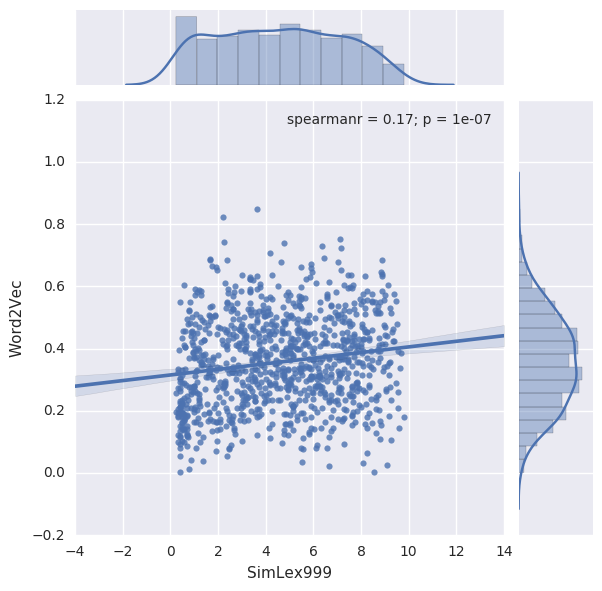

In [62]:
sns.jointplot(
    x=simlex['SimLex999'],
    y=similarity_estimates,
    kind='reg',
    stat_func=sp.stats.spearmanr,
);

In [64]:
similarity_estimates.head()

word1  word2      
old    new            0.309610
smart  intelligent    0.530023
hard   difficult      0.411951
happy  cheerful       0.209461
hard   easy           0.412232
Name: Word2Vec, dtype: float32